In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
import torchvision

In [0]:
import numpy as np
import gzip
import struct
import pickle
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision import transforms

In [21]:
import urllib.request

urllib.request.urlretrieve("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz", "train_features.gz")
urllib.request.urlretrieve("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz", "test_features.gz")


def get_features(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)
    
def plot_image(image):
    plt.imshow(image.reshape((28,28)), cmap="gray")
    
features = get_features("train_features.gz").reshape((10,6000,1,28,28)) / 255
features = torch.from_numpy(features).float().cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


In [0]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.dropout = nn.Dropout2d()
    
    #encoder
    self.e_cnn1 = nn.Conv2d(1,3,(3,3))
    self.e_cnn2 = nn.Conv2d(3,3,(3,3))
    self.e_cnn3 = nn.Conv2d(3,5,(3,3))
    self.e_dense_mean = nn.Linear(2420, 30)
    
    #decoder
    self.d_dense = nn.Linear(30,2880)
    self.d_decnn1 = nn.ConvTranspose2d(5,3,(3,3))
    self.d_decnn2 = nn.ConvTranspose2d(3,1,(3,3))
    
  
  def forward(self, input, generating=False):
    # encoding
    mean, var = None, None
    if not generating: 
      res = self.relu(self.e_cnn1(input))
      res = self.relu(self.e_cnn2(res))
      res = self.relu(self.e_cnn3(res))
      res = res.reshape(input.shape[0], 2420)
      mean = self.relu(self.e_dense_mean(res))
      samples = torch.randn_like(mean)
      input = mean + samples
    
    # decoding
    res = self.relu(self.d_dense(input))
    res = res.reshape(input.shape[0], 5 , 24, 24)
    res = self.relu(self.d_decnn1(res))
    res = self.sigmoid(self.d_decnn2(res))
    return (res,mean)

In [0]:
net = VAE().cuda()

In [65]:
epochs = 200

optimizer = optim.Adam(net.parameters())

for i in range(epochs):
  for j in range(10):
    data = features[j,:,:,:,:]
    generated, mean = net(data)
    loss_reconstruct = (((data - generated) ** 2)).sum() / 6000
    loss_KL = mean.pow(2).sum() * 0.01 / 6000
    loss = (loss_reconstruct + loss_KL)
    loss.backward()
    optimizer.step()
    print("epoch: ", i)
    print("reconstruct loss: ", loss_reconstruct.item())
    print("KL: ", loss_KL.item())
    print("___________")

epoch:  0
reconstruct loss:  178.95164489746094
KL:  0.00047590688336640596
___________
epoch:  0
reconstruct loss:  178.79299926757812
KL:  0.0009799879044294357
___________
epoch:  0
reconstruct loss:  178.22206115722656
KL:  0.0024230051785707474
___________
epoch:  0
reconstruct loss:  177.94041442871094
KL:  0.004446788225322962
___________
epoch:  0
reconstruct loss:  177.65541076660156
KL:  0.007108430843800306
___________
epoch:  0
reconstruct loss:  177.04469299316406
KL:  0.010496004484593868
___________
epoch:  0
reconstruct loss:  176.76954650878906
KL:  0.01474443543702364
___________
epoch:  0
reconstruct loss:  176.21189880371094
KL:  0.019967105239629745
___________
epoch:  0
reconstruct loss:  175.8458251953125
KL:  0.0270366333425045
___________
epoch:  0
reconstruct loss:  175.3955841064453
KL:  0.036516860127449036
___________
epoch:  1
reconstruct loss:  174.94447326660156
KL:  0.04912803694605827
___________
epoch:  1
reconstruct loss:  174.641845703125
KL:  0.065

KeyboardInterrupt: ignored

torch.Size([1, 1, 28, 28])

In [0]:
from matplotlib import pyplot as plt
def plot_image(image):
    plt.imshow(image.detach().cpu().numpy().reshape((28,28)) * 255, cmap="gray")

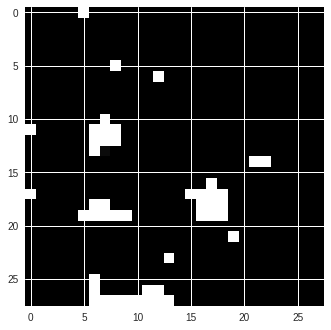

In [74]:
sample = net(torch.randn(1, 30).cuda(), generating=True)[0]
plot_image(sample)